**Author: Fiona Jiaqi Wu** <br> Date: 12/15/2020 <br> Machine Learning Project: Credit Card Loan Default Detection

## Motivations 
For FinTech and traditional banks, detecting loan default is a crucial part of their business model to generate profits. Machine learning techniques play constructive roles in this type of tasks. In this data science project, I use a real life bank dataset which documents customers' characteristics and their credit card loan results. The feature variables are gender, annual income, education level, occupation, age, number of children, family size, etc. The target variables are the loan status for each customers each months. If the loan is less than 90-day past due, it is unlikely to default. Otherwise the loan is likely to default. <br> 

I use **logistic regression**, **random forest**, **support vector machine**, and **gradient boosting** to predict whether or not the customer is likely to default on his or her loans. The following sections are comprised of introduction of the dataset, data visualization, feature selections and correlation analysis, modeling, and conclusions.


In [55]:
import pandas as pd
import numpy as np

## Dataset
The loan dataset comes from Kaggle. The target variable is loan status. I categorize loans which are within 90 days overdue as unlikely to default, otherwise there is a high chance of default. There are 18 explanatory features in the dataset such as gender, if the customer owns a car or house, their living conditions, annual income, education level, etc. Below are some feature visualizations. 67% of the population are women. Customers age ranges from 20 to 69 with a median of 43 years old. The annual household income distribution is highly skewed with a median of 160K. 51% of the customers obtain their income through working. Less than 30% of the customers pursue higher education or have completed their academic degree. 73% of the customers are in a marriage. Finally, **99.797%** of the records belong to unlikely to default in this dataset.

### Import Dataset 

In [56]:
# loading features file
df = pd.read_csv('/Users/Fiona/Desktop/credit card default project/features.csv')
print(df.shape)
df.sort_values(by=['ID'])
n,m = df.shape

column = list(df)
print(column)

(438557, 18)
['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']


In [57]:
# loading target variable file
target = pd.read_csv('/Users/Fiona/Desktop/credit card default project/target.csv')
target.head().T

,0,1,2,3,4
ID,5001711,5001711,5001711,5001711,5001712
MONTHS_BALANCE,0,-1,-2,-3,0
STATUS,X,0,0,0,C


In [58]:
# find the intersection of the index/ID
valid_indexes = list(set(df.index).intersection(set(target.index))) 
len( valid_indexes )
df = df.loc[valid_indexes]
target = target.loc[valid_indexes]
print(df.shape)
print(target.shape)

(438557, 18)
(438557, 3)


### Merge Datasets

In [59]:
# Merge the datasets
record = pd.merge(target, df, on='ID', how='right')
record.head()

,ID,MONTHS_BALANCE,STATUS,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,0.0,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008804,-1.0,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008804,-2.0,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
3,5008804,-3.0,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
4,5008804,-4.0,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0


### Data Cleaning

In [60]:
# convert days_birth to Age
record['Age'] = -record['DAYS_BIRTH']/(365)
record.shape

(682688, 21)

**Converting Status to Default (1) or Healthy (0) customers based on loan past due days** <br> Status (y target) meanings <br> 0: 1-29 days past due <br> 1: 30-59 days past due <br> 2: 60-89 days overdue <br> 3: 90-119 days overdue <br> 4: 120-149 days overdue <br> 5: Overdue or bad debts, write-offs for more than 150 days <br> C: paid off that month <br> X: No loan for the month <br> **C, X, 0, 1, 2 --> healthy customers <br> 3, 4 ,5 --> default customers**

In [61]:
def status(x):
    if x == 'C' or x == 'X' or x == '0' or x == '1' or x == '2':
        return 0
    elif x == '3' or x == '4' or x == '5':
        return 1

record['STATUS_BIN']=record['STATUS'].apply(lambda x: status(x))
record.head()

,ID,MONTHS_BALANCE,STATUS,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Age,STATUS_BIN
0,5008804,0.0,C,M,Y,Y,0,427500.0,Working,Higher education,...,-12005,-4542,1,1,0,0,NaN,2.0,32.890411,0.0
1,5008804,-1.0,C,M,Y,Y,0,427500.0,Working,Higher education,...,-12005,-4542,1,1,0,0,NaN,2.0,32.890411,0.0
2,5008804,-2.0,C,M,Y,Y,0,427500.0,Working,Higher education,...,-12005,-4542,1,1,0,0,NaN,2.0,32.890411,0.0
3,5008804,-3.0,C,M,Y,Y,0,427500.0,Working,Higher education,...,-12005,-4542,1,1,0,0,NaN,2.0,32.890411,0.0
4,5008804,-4.0,C,M,Y,Y,0,427500.0,Working,Higher education,...,-12005,-4542,1,1,0,0,NaN,2.0,32.890411,0.0


In [62]:
# Occupation has many NaN values, replace NaN with the most common values in this category
mode = df[column[-2]].mode()
print('The most common value is:', mode)
record[column[-2]] = record[column[-2]].fillna(mode)
# drop any missing values in the dataset
record.dropna(inplace=True)
record.shape

The most common value is: 0    Laborers
dtype: object


(175375, 22)

## Features Visualizations
There are 18 feature variables and 1 target variable in this merged dataset. The following shows visualization of 8 variables.

### Loan Status

Text(0.5, 1.0, 'Loan Status')

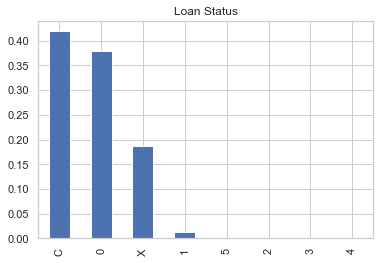

In [80]:
status = record['STATUS'].value_counts(normalize = True)
status.plot.bar()
plt.title('Loan Status')

### Gender

Text(0.5, 1.0, 'Gender ratio')

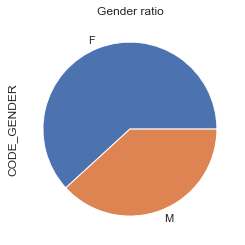

In [81]:
gender = record['CODE_GENDER'].value_counts(normalize = True)
gender.plot.pie()
plt.title('Gender ratio')

### Annual Income

Text(0.5, 1.0, 'Annual Houshold Income Distribution')

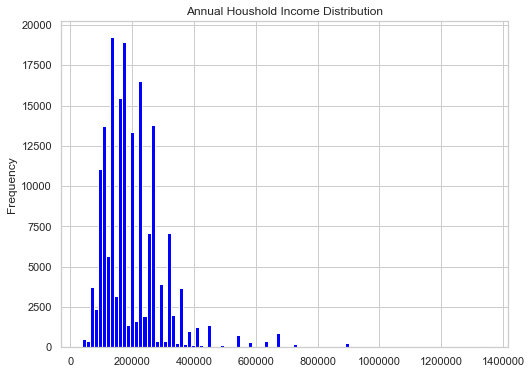

In [82]:
record['AMT_INCOME_TOTAL'].plot(kind = "hist", bins = 100, color = "blue", figsize = (8,6))
plt.title('Annual Houshold Income Distribution')

Text(0.5, 1.0, 'Annual Household Income Boxplot')

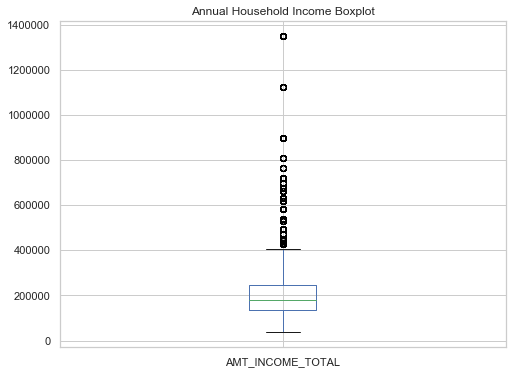

In [83]:
record['AMT_INCOME_TOTAL'].plot(kind = "box", figsize = (8,6))
plt.title("Annual Household Income Boxplot")

### Income Type

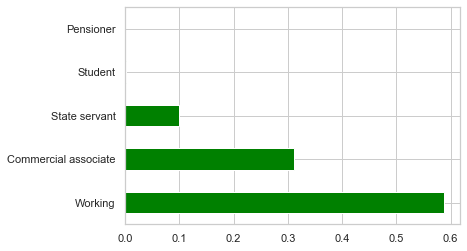

In [84]:
Income_type = record['NAME_INCOME_TYPE'].value_counts(normalize = True)
Income_type.plot(kind = 'barh', figsize = (6,4), color = 'green')

### Age Distribution

Text(0.5, 1.0, 'Age Distribution')

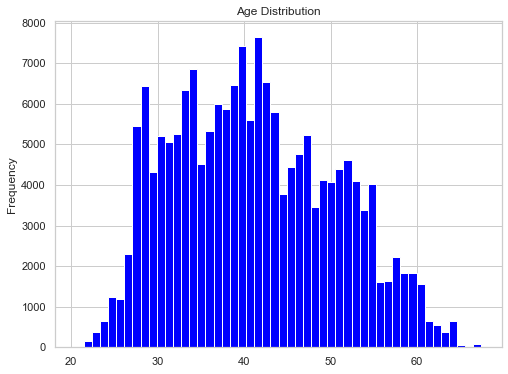

In [85]:
record['Age'].plot(kind = "hist", bins = 50, color = "blue", figsize = (8,6))
plt.title('Age Distribution')

### Education Level

Text(0.5, 1.0, 'Education Level')

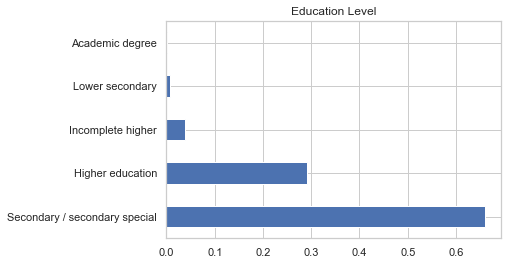

In [86]:
education = record['NAME_EDUCATION_TYPE'].value_counts(normalize = True)
education.plot(kind = 'barh', figsize = (6,4))
plt.title('Education Level')

### Marriage Status 

Text(0.5, 1.0, 'Marriage Status')

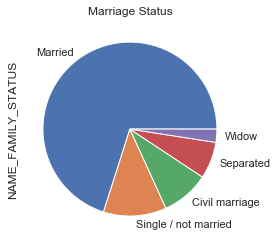

In [87]:
FamilyStatus= record['NAME_FAMILY_STATUS'].value_counts(normalize = True)
FamilyStatus.plot(kind = 'pie')
plt.title('Marriage Status')

### Occupations

Text(0.5, 1.0, 'Occupations')

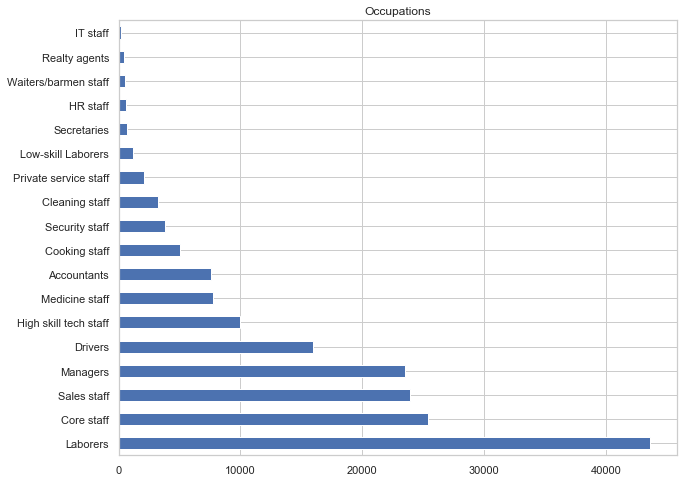

In [94]:
plt.figure(figsize = (10,8))
record['OCCUPATION_TYPE'].value_counts().plot(kind = 'barh')
plt.title('Occupations')

**Convert categorical variables into numerical variables**

In [63]:
record["CODE_GENDER"] = record["CODE_GENDER"].astype('category')
record["Gender_Nu"] = record["CODE_GENDER"].cat.codes
record["FLAG_OWN_CAR"] = record["FLAG_OWN_CAR"].astype('category')
record["Car_Nu"] = record["FLAG_OWN_CAR"].cat.codes
record["FLAG_OWN_REALTY"] = record["FLAG_OWN_REALTY"].astype('category')
record["Realty_Nu"] = record["FLAG_OWN_REALTY"].cat.codes
record["NAME_INCOME_TYPE"] = record["NAME_INCOME_TYPE"].astype('category')
record["Income_type_Nu"] = record["NAME_INCOME_TYPE"].cat.codes
record["NAME_EDUCATION_TYPE"] = record["NAME_EDUCATION_TYPE"].astype('category')
record["Education_Nu"] = record["NAME_EDUCATION_TYPE"].cat.codes
record["NAME_FAMILY_STATUS"] = record["NAME_FAMILY_STATUS"].astype('category')
record["Fam_Status_Nu"] = record["NAME_FAMILY_STATUS"].cat.codes
record["NAME_HOUSING_TYPE"] = record["NAME_HOUSING_TYPE"].astype('category')
record["Housing_Nu"] = record["NAME_HOUSING_TYPE"].cat.codes
record["OCCUPATION_TYPE"] = record["OCCUPATION_TYPE"].astype('category')
record["Occupation_Nu"] = record["OCCUPATION_TYPE"].cat.codes

In [100]:
record.head()

,ID,MONTHS_BALANCE,STATUS,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,Age,STATUS_BIN,Gender_Nu,Car_Nu,Realty_Nu,Income_type_Nu,Education_Nu,Fam_Status_Nu,Housing_Nu,Occupation_Nu
0,5008804,0.0,C,M,Y,Y,0,427500.0,Working,Higher education,...,32.890411,0.0,1,1,1,4,1,0,4,8
31,5008806,0.0,C,M,Y,Y,0,112500.0,Working,Secondary / secondary special,...,58.832877,0.0,1,1,1,4,4,1,1,16
32,5008806,-1.0,C,M,Y,Y,0,112500.0,Working,Secondary / secondary special,...,58.832877,0.0,1,1,1,4,4,1,1,16
33,5008806,-2.0,C,M,Y,Y,0,112500.0,Working,Secondary / secondary special,...,58.832877,0.0,1,1,1,4,4,1,1,16
34,5008806,-3.0,C,M,Y,Y,0,112500.0,Working,Secondary / secondary special,...,58.832877,0.0,1,1,1,4,4,1,1,16


In [11]:
record['STATUS_BIN'].value_counts()

0.0    175019
1.0       356
Name: STATUS_BIN, dtype: int64

In [18]:
# only 0.2% of the customers in the sample are facing default. 99.8% are good customers.
print(356/(175034+356) *100,'% of the cutomers are risking default')
print(100-356/(175034+356) *100, '% of the customers are good ones')

0.20297622441416271 % of the cutomers are risking default
99.79702377558584 % of the customers are good ones


## Features Correlations

In [13]:
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [14]:
record.columns

Index(['ID', 'MONTHS_BALANCE', 'STATUS', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'Age', 'STATUS_BIN', 'Gender_Nu', 'Car_Nu',
       'Realty_Nu', 'Income_type_Nu', 'Education_Nu', 'Fam_Status_Nu',
       'Housing_Nu', 'Occupation_Nu'],
      dtype='object')

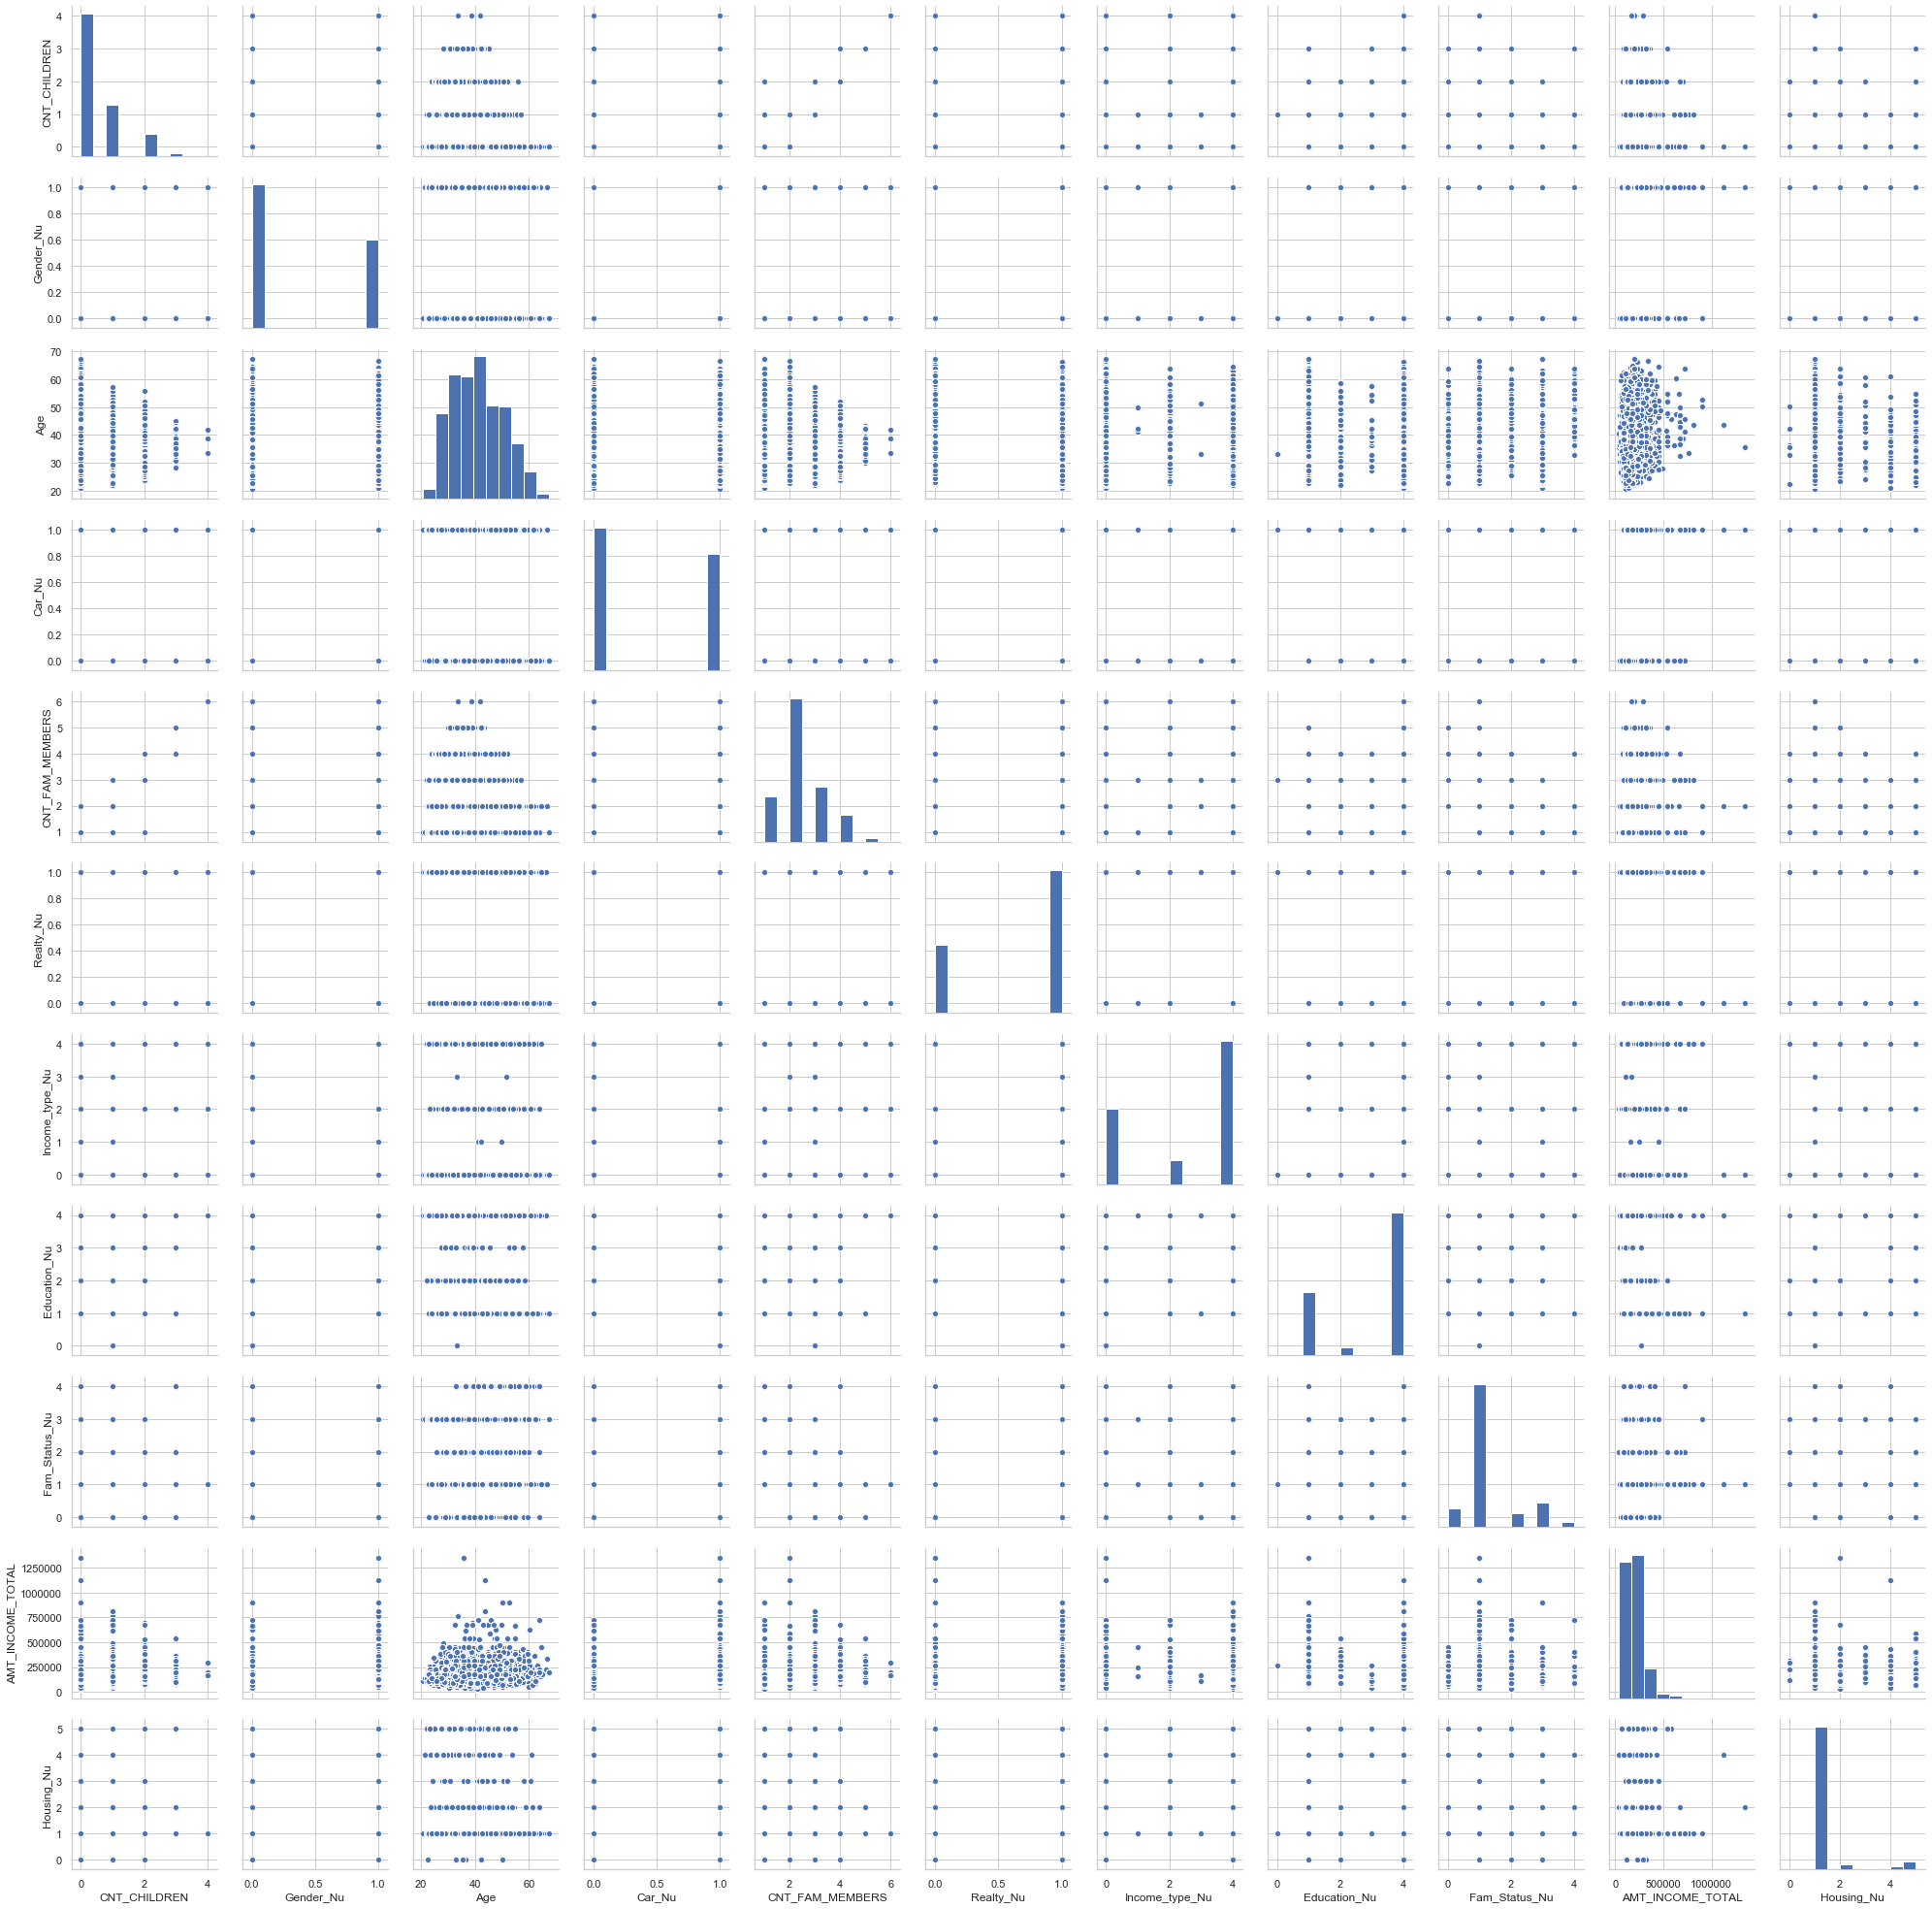

In [15]:
sns.pairplot(record[['CNT_CHILDREN','Gender_Nu', 'Age', 'Car_Nu', 'CNT_FAM_MEMBERS',
       'Realty_Nu', 'Income_type_Nu', 'Education_Nu', 'Fam_Status_Nu', 'AMT_INCOME_TOTAL','STATUS',
       'Housing_Nu']])

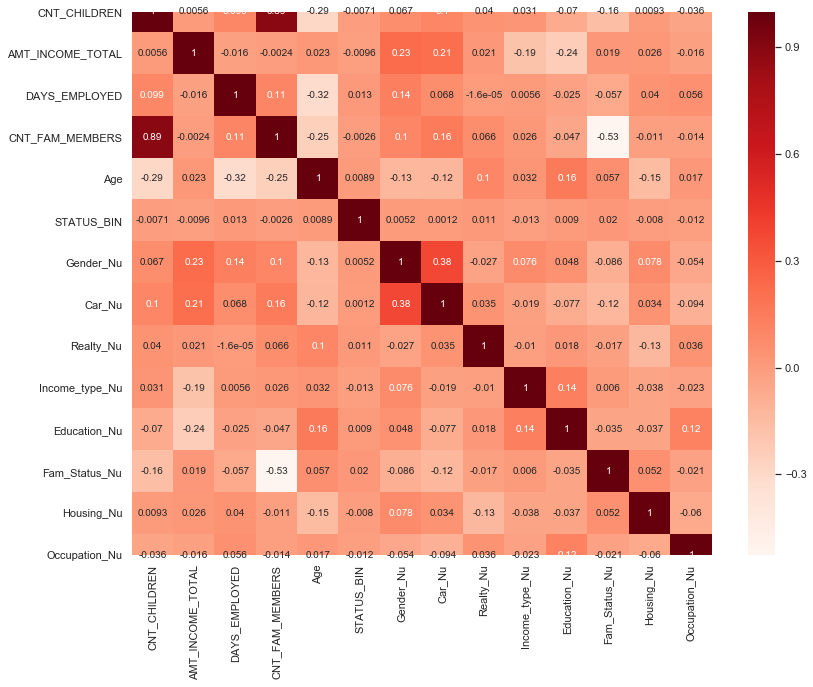

In [16]:
## Feature Correlation method Pearson
corr = record[['CNT_CHILDREN', 'AMT_INCOME_TOTAL','DAYS_EMPLOYED','CNT_FAM_MEMBERS', 'Age', 'STATUS_BIN', 'Gender_Nu', 'Car_Nu',
       'Realty_Nu', 'Income_type_Nu', 'Education_Nu', 'Fam_Status_Nu',
       'Housing_Nu', 'Occupation_Nu']].corr()

plt.figure(figsize = (13,10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True, cmap=plt.cm.Reds)

## Sampling and Train-Test Split
I randomly choose 100K observations from the sample. 70% of the randomly choosen observations are used as the training set to train the model, and the rest of the 30% is used to test model accuracy. The features include number of children, total annual income, number of family members, age, gender, if they have a car, if they have a house, etc. The target variable is the binary version of loan status, where 1 indicates default and 0 indicates healthy.

In [ ]:
record_sample = record.sample(100000, random_state = 9)
record_sample['STATUS'].value_counts()
train,test = train_test_split(record_sample,test_size=0.3, random_state=21)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
Features = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL','CNT_FAM_MEMBERS', 'Age', 'Gender_Nu', 'Car_Nu',
       'Realty_Nu', 'Income_type_Nu', 'Education_Nu', 'Fam_Status_Nu','Housing_Nu','Occupation_Nu']
Targets = ['STATUS_BIN']
train_x = train[Features]
train_y =train[Targets]
test_x = test[Features]
test_y =test[Targets]

## Feature Selections
To examine which features influence the prediction outcome the most, I perform a univariate feature selection by computing chi-squared stats between each non-negative feature and class. As shown in the table, total annual income, age, occupation, income type, and family status are the top five features which statistically significantly impact the prediction outcome. The p-values for these features are extremely small which means the results are robust with a 99% confidence interval. 

In [48]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [77]:
select_feature = SelectKBest(chi2, k=10).fit(train_x, train_y)
a = select_feature.scores_
b = select_feature.pvalues_

In [78]:
features_rank = pd.DataFrame({'Score': a, 'p-values': b, 'Features': Features}, columns=['Score', 'p-values','Features'])
features_rank.set_index(['Features'])
features_rank = features_rank.sort_values(by = ['Score'], ascending=False)
features_rank.set_index(['Features'], inplace = True)
features_rank

,Score,p-values
Features,,
AMT_INCOME_TOTAL,224687.113261,0.000000e+00
Age,24.168349,8.827110e-07
Occupation_Nu,24.125943,9.023639e-07
Income_type_Nu,18.308389,1.878780e-05
Fam_Status_Nu,10.410290,1.253150e-03
Education_Nu,4.588032,3.219595e-02
Housing_Nu,3.440561,6.361411e-02
Realty_Nu,2.894984,8.885565e-02
CNT_CHILDREN,1.154119,2.826886e-01


## Modeling
I use various supervised learning techniqes such as logistic regression, random forest, support vector machine, and gradient boosting to predict if a loan is likely to default. In this real life loan dataset, 99.797% of the loans are unlikely to default, and only 0.203% of the loans are defaulting. This makes a simple model which always predicts the loan is not going to default has an accuaray of 99.797%. A model which has accuracy lower than 99.797% performs worse than the simple model. The accuracy of logistic regression is sligtly below this threshold. However, random forest, support vector machine, and gradient boosting all have accuracy score higher than the threhold and above 99.8%. Among the three, **support vector machine** has the highest prediction accuracy. <br> 

There are a number of reasons that support vector machine (SVM) is the winner in this loan default prediction project. SVM is particularly useful in high dimensional spaces. This dataset has 18 predictive features and makes it high dimensional. In addtion, SVM uses a subset of training points in the decision function (called support vectors), so it is also memory efficient. Finally, I can specify different Kernel functions for the decision function.

### Logistic Regression

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
lr = LogisticRegression(C=0.8, random_state=0)
lr.fit(train_x,train_y)
predict_y = model.predict(test_x)
print('Accuracy Score is {:.5}'.format(accuracy_score(test_y, predict_y)))

Accuracy Score is 0.99783


### Random Forest 

In [34]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 0)
rf.fit(train_x, train_y)
y_rf = rf.predict(test_x)
print('Accuracy Score is {:.5}'.format(accuracy_score(test_y, y_rf)))

Accuracy Score is 0.99803


### Support Vector Machine

In [33]:
from sklearn.svm import SVC
svc = SVC(kernel = 'rbf', gamma = 'auto')
svc.fit(train_x, train_y)
y_svc = svc.predict(test_x)
print('Accuracy Score is {:.5}'.format(accuracy_score(test_y, y_svc)))

Accuracy Score is 0.99813


### Gradient Boosting 

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(train_x, train_y)
y_gb = gb.predict(test_x)
print('Accuracy Score is {:.5}'.format(accuracy_score(test_y, y_gb)))

Accuracy Score is 0.998


## Conclusions
In this machine learning credit card loan default detection project, I use a real life loan dataset from Kaggle and varaious machine learning techniques to predict if a loan is likely to default. Predicting loan default is an essential task for many FinTech lenders and traditional banks. Through analyzing the characteristics of the customers who are likely to go default, FinTech lenders and banks can screen out those customers in the future, thus reducing loan default rates, making more loans to credible customers, and increasing customer satisfaction. With the high dimensional 18 predictive features dataset, I conclude that support vector machine is the winner in this predictive task. <br>

For further exploration, one can use unsupervised learning such as K-Means or K-Modes to for customer segementations and categorize customers into likely or unlikely to default basket. Customer segmentation is crucial for banks to decide whether or not they would issue a loan to a new or existing customer, and at which interest rates they are issuing the loan. It is also helpful to identify the best communication channels for different groups, therefore enhancing customer relationships and developing more personalized customer service. Most importantly, it helps banks to allocate resources and focus on the most profitable customer groups. If one is interested in experimenting more with this dataset, unsupervised learning and customer segementations are promising directions to explore. 